In [17]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive') # Comment after mounting drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive". 
# This cell presents the contents of the supporting files directory
# Next cell gets you to the supporting files directory
!ls "/content/drive/MyDrive/ktd1g20_COMP6247/OutputFileGeneration"

COMP6247Maze20212022.npy    __pycache__
my_excel_file_maze.xlsx     QtableA_reshapedWinnerStatic.xlsx
OutputFileGeneration.ipynb  read_maze.py


In [19]:
cd "/content/drive/MyDrive/ktd1g20_COMP6247/OutputFileGeneration" 

/content/drive/MyDrive/ktd1g20_COMP6247/OutputFileGeneration


In [20]:
# The libraries that are needed

import numpy as np
import pandas as pd                                             
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [21]:
# This imports the functions from the read_maze.py file.
from read_maze import *

In [22]:
# This will load the maze
load_maze()

In [23]:
# We need a function that gives us the state the agent is in.
# The function takes as input the coordinates (x,y) of the agent's current location.
# The output is a list of 20 elements
# The first 9 elements correspond to the walls surrounding the agent
# The second 9 elements correspond to the fire surrounding the agent
# The last two elements correspond to (x,y) coordinates of the agent's position (similar to the input)

def get_state(x,y): 
  info_array = get_local_maze_information(int(x), int(y))
  sides_array = np.zeros((3,3))
  fires_array = np.zeros((3,3))
  for i in range(3):
    for j in range(3):
      sides_array[i][j] = info_array[i][j][0] # The spatial geometry
      fires_array[i][j] = info_array[i][j][1] # The fire geometry

  my_list = sides_array.flatten().tolist() + fires_array.flatten().tolist()
  my_list.append(x)
  my_list.append(y)
  state_array = np.array([my_list])
  
  return state_array

In [24]:
# This function gets the action from the Q-table by comparing the corresponding Q-values.
# The inputs are the Q-table and the state the agent is in.
# The output is the action the agent should take, represented as a number

def get_action_from_Qtable(Qtable, state): 
  x_state = int(state[0][-2])
  y_state = int(state[0][-1])
  local_state = state
  q = Qtable[x_state][y_state]
  action = float(np.argmax(q)) 

  return action 

In [25]:
# This is the function that enables the agent to move. 
# The inputs are the state the agent is in and the action it will take based on the Q-table.
# The outputs are the new_state and a Boolean variable that is added in order to allow the agent to always reach the (199,199) tile.

def actTest(state, action):
  temp_action = float(action)
  resetAgent = False # The addition of this variable enables the agent to effectively reach the (199,199) tile.

  start_x = state[0][-2] # Our starting coordinates before the action
  start_y = state[0][-1]
  old_state = state

  new_x = state[0][-2] # Our coordinates after the action. Initialised as the starting coordinates.
  new_y = state[0][-1]
  new_state = state

  if (temp_action == 0) and (old_state[0][3] == 1) and (old_state[0][12] == 0): # Valid left
    new_y -= 1
    new_state = get_state(new_x, new_y)
    return new_state, resetAgent

  elif (temp_action == 1) and (old_state[0][1] == 1) and (old_state[0][10] == 0): # Valid up
    new_x -= 1
    new_state = get_state(new_x, new_y)
    return new_state, resetAgent
    
  elif (temp_action == 2) and (old_state[0][5] == 1) and (old_state[0][14] == 0): # Valid right
    new_y += 1
    new_state = get_state(new_x, new_y)
    return new_state, resetAgent

  elif (temp_action == 3) and (old_state[0][7] == 1) and (old_state[0][16] == 0): # Valid down
    new_x += 1
    new_state = get_state(new_x, new_y)
    return new_state, resetAgent
  
  else: # Invalid move. This will be corrected in the process of generating the output file below.
    resetAgent = True
    new_state = get_state(new_x, new_y)
    return new_state, resetAgent 

In [26]:
loaded_QtableA = pd.read_excel('QtableA_reshapedWinnerStatic.xlsx', index_col=0  ) # Import the trained Q-table 
loaded_QtableA = loaded_QtableA.to_numpy()

QtableA = np.zeros((201,201,4)) # Initialise the Q-table variable that the trained Q-table will be copied in.
QtableA = loaded_QtableA.reshape(loaded_QtableA.shape[0], loaded_QtableA.shape[1] // QtableA.shape[2], QtableA.shape[2])

In [27]:
# Initialise some constants for the problem

target = (199, 199) # Our objective tile.

# We will encode the actions as follows:
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3
REMAIN = 4 

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down' ,
    REMAIN: 'remain' 
}

In [32]:
# This opens a text file to write the output file on
df=open('output_file.txt','w')

In [33]:
add_column = np.zeros((201,1)) # An auxiliary column for the correct representation of the maze to create the output heatmap.

trajectory_array = pd.read_excel('my_excel_file_maze.xlsx', index_col =0) # The maze array.
trajectory_array = trajectory_array.to_numpy()
trajectory_array = np.concatenate((add_column, trajectory_array), axis = 1)

# The output file generation process:

starting_point_x = 1.0 # Starting coordinates
starting_point_y = 1.0
trajectory_array[int(starting_point_x)][int(starting_point_y)] += 5 # This will help to make the heatmap in the following steps
number_steps = 0 # This will count how many steps were needed to reach the (199,199) tile

state = get_state(starting_point_x, starting_point_y) # The starting state

# Main loop
while (starting_point_x != 199.0) or (starting_point_y != 199.0):
  
  # Local information
  surrounding_array = np.array([[state[0][0], state[0][1], state[0][2]], [state[0][3], state[0][4], state[0][5]], [state[0][6], state[0][7], state[0][8]]] ) 
  fire_array = np.array([[state[0][9], state[0][10], state[0][11]], [state[0][12], state[0][13], state[0][14]], [state[0][15], state[0][16], state[0][17]]] )

  # Selection of action
  action = get_action_from_Qtable(QtableA, state)
  
  # Get the new state
  new_state, resetAgent  = actTest(state, action)

  # Print and write accordingly:
  print("Initial position: ", [state[0][-2], state[0][-1]])
  df.write("Initial position: " + str([state[0][-2],state[0][-1]]) + "\n")

  print("Environment observed:")
  df.write("Environment observed:" + "\n")

  print("Walls information: ")
  df.write("Walls information: " + "\n")

  print(surrounding_array)
  df.write(str(surrounding_array) + "\n")

  print("Fire information: ")
  df.write("Fire information: " + "\n")

  print(fire_array)
  df.write(str(fire_array) + "\n")

  # This part enables the agent to always reach the (199,199) file in order to always have an output file generated
  if resetAgent == True:
    action = 4 
    print("Action taken: " +  actions_dict[int(action)] )
    df.write("Action taken: " + str(actions_dict[int(action)]) + "\n")
  else:
    print("Action taken: " + actions_dict[int(action)] )
    df.write("Action taken: " + str(actions_dict[int(action)]) + "\n")

  print("Move made: " , [state[0][-2], state[0][-1]] , " -> " , actions_dict[int(action)] , " -> ", [new_state[0][-2], new_state[0][-1]])
  df.write("Move made: " + str([state[0][-2], state[0][-1]]) + " -> " + str(actions_dict[int(action)]) + " -> " + str([new_state[0][-2], new_state[0][-1]])+ "\n")

  print("-------------------------------------------------------------------------------")
  df.write("-------------------------------------------------------------------------------" + "\n")
  
  number_steps += 1

  # Update the state features
  starting_point_x = new_state[0][-2]
  starting_point_y = new_state[0][-1]
  state = new_state

  # This will help to make the heatmap in the following steps
  trajectory_array[int(starting_point_x)][int(starting_point_y)] += 5

print("It took us: ", number_steps, " steps to reach the (199,199) tile." + "\n")
df.write("It took us: " + str(number_steps) + " steps to reach the (199,199) tile." + "\n")

Streaming output truncated to the last 5000 lines.
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
Action taken: left
Move made:  [163.0, 195.0]  ->  left  ->  [163.0, 194.0]
-------------------------------------------------------------------------------
Initial position:  [163.0, 194.0]
Environment observed:
Walls information: 
[[0. 0. 1.]
 [1. 1. 1.]
 [1. 0. 0.]]
Fire information: 
[[0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]]
Action taken: left
Move made:  [163.0, 194.0]  ->  left  ->  [163.0, 193.0]
-------------------------------------------------------------------------------
Initial position:  [163.0, 193.0]
Environment observed:
Walls information: 
[[0. 0. 0.]
 [0. 1. 1.]
 [0. 1. 0.]]
Fire information: 
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
Action taken: down
Move made:  [163.0, 193.0]  ->  down  ->  [164.0, 193.0]
-------------------------------------------------------------------------------
Initial position:  [164.0, 193.0]
Environment observed:
Walls information: 
[[0. 1. 1.]
 [0. 1. 0.]
 [1. 1

52

In [30]:
# Make sure to close the text file so that all of the data have been written on it.
# The output file can then be found in the same file we are working on: "/content/drive/MyDrive/ktd1g20_COMP6247/OutputFileGeneration"
df.close()

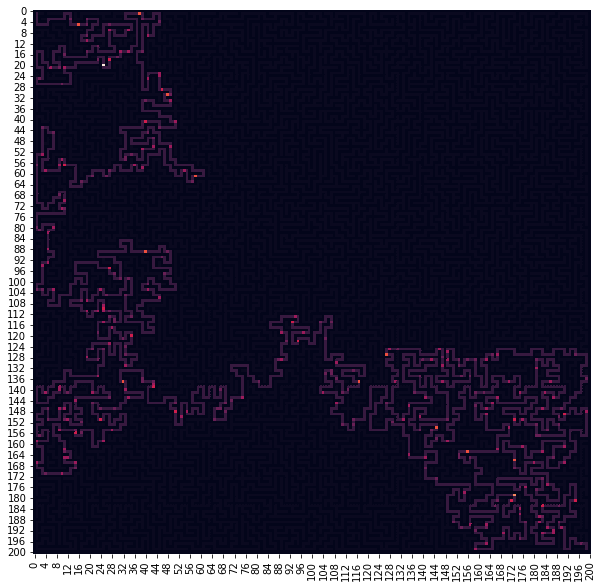

In [31]:
# Generate the heatmap. Brighter colours represent locations that the agent spent more time due to the dynamic elements of the maze.
fig = plt.figure(figsize = (10,10))
sns.heatmap(trajectory_array, cbar = False)